In [192]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Load Data

In [193]:
# Load the data as numpy arrays
img_1 = pd.read_csv('./../data/feaSubEImg_1.csv', header=None).to_numpy()
img_2 = pd.read_csv('./../data/feaSubEImg_2.csv', header=None).to_numpy()
overt_1 = pd.read_csv('./../data/feaSubEOvert_1.csv', header=None).to_numpy()
overt_2 = pd.read_csv('./../data/feaSubEOvert_2.csv', header=None).to_numpy()

In [194]:
# Combine the features
img_X = np.hstack((img_1, img_2)).T
img_y = np.array([0] * img_1.shape[1] + [1] * img_2.shape[1])

overt_X = np.hstack((overt_1, overt_2)).T
overt_y = np.array([0] * overt_1.shape[1] + [1] * overt_2.shape[1])

### Function to plot all ROCs

In [195]:
# Plot ROC curves for all folds
def plot_all_fold_rocs(y_true_all, decision_scores_all, outer_splits=6, title="Overt Movement: ROC per Fold"):
    fold_size = len(y_true_all) // outer_splits
    plt.figure(figsize=(8, 8))

    for fold in range(outer_splits):
        start = fold * fold_size
        end = (fold + 1) * fold_size

        y_fold = y_true_all[start:end]
        score_fold = decision_scores_all[start:end]

        fpr, tpr, _ = roc_curve(y_fold, score_fold)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2.5, label=f'Fold {fold+1} Acc = {roc_auc:.2f}')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1.2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [196]:
# Plot average ROC curve 
def plot_average_roc(y_true_all, decision_scores_all, outer_splits=6, title="Average ROC Curve"):
    fold_size = len(y_true_all) // outer_splits
    fpr_grid = np.linspace(0, 1, 100)
    tprs_interp = []

    for fold in range(outer_splits):
        start = fold * fold_size
        end = (fold + 1) * fold_size

        y_fold = y_true_all[start:end]
        score_fold = decision_scores_all[start:end]

        fpr, tpr, _ = roc_curve(y_fold, score_fold)
        tpr_interp = np.interp(fpr_grid, fpr, tpr)
        tpr_interp[0] = 0.0 
        tprs_interp.append(tpr_interp)

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0  # force the end to 1
    mean_auc = auc(fpr_grid, mean_tpr)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(fpr_grid, mean_tpr, color='blue', lw=2.5, label=f"Average ROC (Acc = {mean_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1.2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Two-level Cross-validation function

In [197]:
# Inner cross-validation
def inner_cv(X_train, y_train, C_values=[0.01, 1, 100, 10000], n_splits=5):
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    val_accuracies = {C: [] for C in C_values}

    # Iterate through each fold
    for train_idx, val_idx in skf.split(X_train, y_train):
        # Get the data for the fold
        X_inner_train, X_val = X_train[train_idx], X_train[val_idx]
        y_inner_train, y_val = y_train[train_idx], y_train[val_idx]

        # For each fold, train and evaluate the model for each C value
        for C in C_values:
            clf = SVC(kernel='linear', C=C)
            clf.fit(X_inner_train, y_inner_train)
            y_val_pred = clf.predict(X_val)
            acc = accuracy_score(y_val, y_val_pred)
            val_accuracies[C].append(acc)

    avg_acc = {C: np.mean(accs) for C, accs in val_accuracies.items()}
    best_C = max(avg_acc, key=avg_acc.get)
    return best_C, val_accuracies

In [198]:
def two_level_cross_validation(X, y, outer_splits=6, inner_splits=5, C_values=[0.01, 1, 100, 10000]):
    # Split the data into 6 folds
    outer_skf = StratifiedKFold(n_splits=outer_splits, shuffle=True)

    accuracies = []
    best_Cs = []
    y_true_all = []
    y_pred_all = []
    decision_scores_all = []

    # Iterate through each outer fold
    for fold_idx, (train_idx, test_idx) in enumerate(outer_skf.split(X, y)):
        # Get the training and test data for the outer fold
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Inner CV to find best C
        best_C, _ = inner_cv(X_train, y_train, C_values=C_values, n_splits=inner_splits)
        best_Cs.append(best_C)

        # Train final model on all outer training data using best C
        model = SVC(kernel='linear', C=best_C)
        model.fit(X_train, y_train)

        # Evaluate on outer test fold
        y_pred = model.predict(X_test)
        decision_scores = model.decision_function(X_test)
        acc = accuracy_score(y_test, y_pred)

        # Store results
        accuracies.append(acc)
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        decision_scores_all.extend(decision_scores)

        print(f"[Fold {fold_idx+1}] Accuracy: {acc:.2f}, Best C: {best_C}")

    return {
        'accuracies': accuracies,
        'best_Cs': best_Cs,
        'y_true_all': np.array(y_true_all),
        'y_pred_all': np.array(y_pred_all),
        'decision_scores_all': np.array(decision_scores_all)
    }

### Evaluate on Overt Data

In [199]:
# C values to test
C_values = [
    0.0001, 0.000316, 0.001, 0.00316, 0.01, 0.0316,
    0.1, 0.316, 1.0, 3.16, 10.0, 31.6, 100.0
]


In [200]:
results_overt = two_level_cross_validation(X=overt_X, y=overt_y, C_values=C_values)

print("\nAverage outer CV accuracy:", np.mean(results_overt['accuracies']))
print("Best C values per fold:", results_overt['best_Cs'])

[Fold 1] Accuracy: 0.97, Best C: 0.0001
[Fold 2] Accuracy: 0.95, Best C: 0.0001
[Fold 3] Accuracy: 0.95, Best C: 0.0001
[Fold 4] Accuracy: 0.95, Best C: 0.0001
[Fold 5] Accuracy: 0.97, Best C: 0.0001
[Fold 6] Accuracy: 0.90, Best C: 0.0001

Average outer CV accuracy: 0.9500000000000001
Best C values per fold: [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]


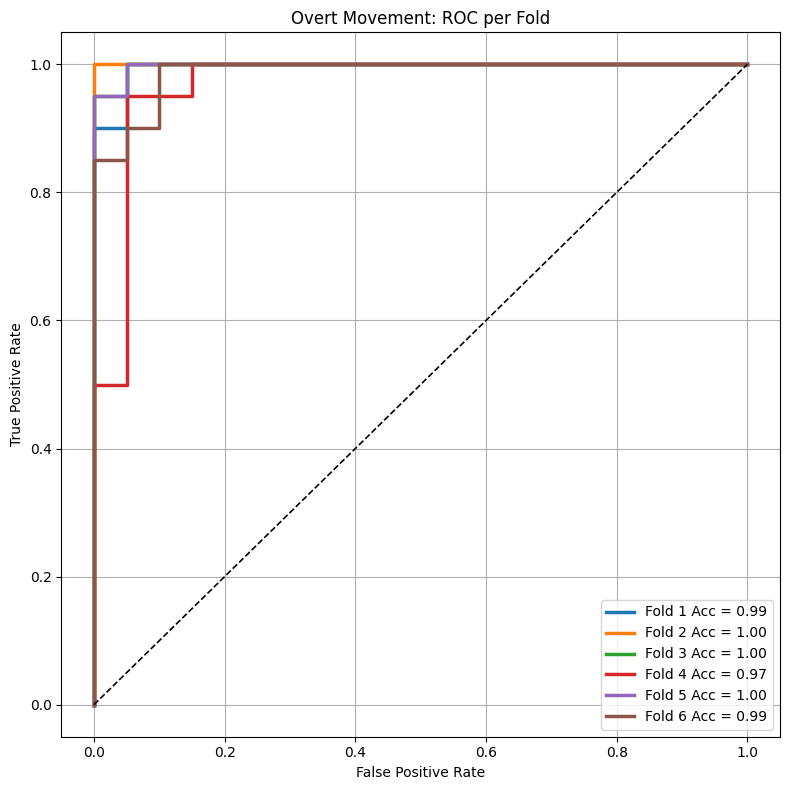

In [201]:
# Plot ROC curves for all folds
plot_all_fold_rocs(results_overt['y_true_all'], results_overt['decision_scores_all'])

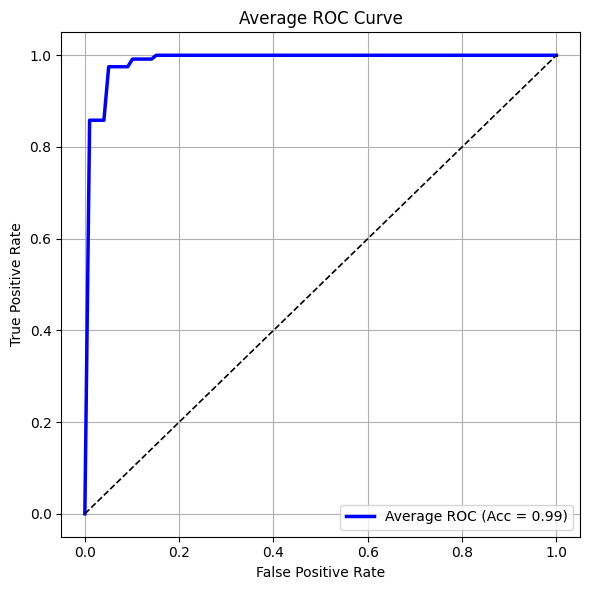

In [202]:
# Average ROC
plot_average_roc(results_overt['y_true_all'], results_overt['decision_scores_all'])

### Evaluate on Imagined Movement

In [203]:
results_img = two_level_cross_validation(X=overt_X, y=overt_y, C_values=C_values)

print("\nAverage outer CV accuracy:", np.mean(results_img['accuracies']))
print("Best C values per fold:", results_img['best_Cs'])

[Fold 1] Accuracy: 1.00, Best C: 0.0001
[Fold 2] Accuracy: 0.93, Best C: 0.0001
[Fold 3] Accuracy: 0.97, Best C: 0.0001
[Fold 4] Accuracy: 0.97, Best C: 0.0001
[Fold 5] Accuracy: 1.00, Best C: 0.0001
[Fold 6] Accuracy: 0.93, Best C: 0.0001

Average outer CV accuracy: 0.9666666666666667
Best C values per fold: [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]


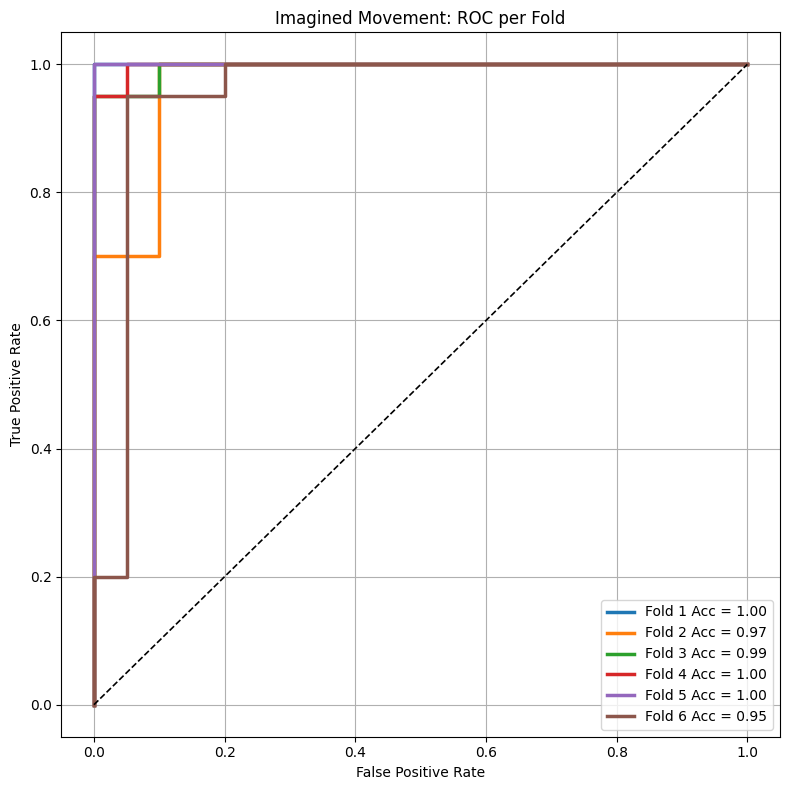

In [204]:
# Plot ROC curves for all folds
plot_all_fold_rocs(results_img['y_true_all'], results_img['decision_scores_all'], title="Imagined Movement: ROC per Fold")

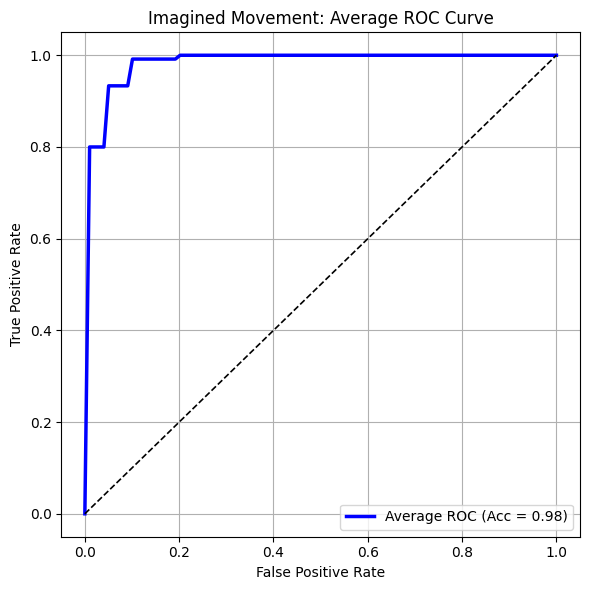

In [205]:
# Plot Average ROC
plot_average_roc(results_img['y_true_all'], results_img['decision_scores_all'], title="Imagined Movement: Average ROC Curve")